In [6]:
import os
import numpy as np
import time
import copy
import sys
import re

import scipy.io

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import atomistic_tools.cp2k_stm_utilities as csu

In [7]:
folder = "/home/kristjan/local_work/z5_cu110/"
file_basis_set = folder + "BR"
file_xyz = folder + "2z5_cu_i1-opt.xyz"
file_restart = folder + "PROJ-RESTART.wfn"
file_cp2k_inp = folder + "cp2k.inp"

In [53]:
emin = -0.1
emax =  0.1

time1 = time.time()
elem_basis_names, cell = csu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = csu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

time1 = time.time()
ase_atoms = csu.read_xyz(file_xyz)
csu.center_atoms_to_cell(ase_atoms.positions, cell/ang_2_bohr)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
morb_composition, morb_energies, morb_occs, homo_inds, ref_en = load_restart_wfn_file(file_restart, emin, emax, 6, 10)
print("Found %d orbitals" % len(morb_energies[0]))
print("Read restart: %.3f" % (time.time()-time1))

Read cp2k input: 0.003
Read basis sets: 0.005
Read xyz: 0.008
7312 7360
5
7342 7346
Found 5 orbitals
Read restart: 6.788


In [8]:
# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.2 # Good to choose a factor of the lattice parameter 4.26
step *= ang_2_bohr
cell_n = (np.round(cell/step)).astype(int)

# Other possiblity: define cell_n directly
#cell_n = np.array([75, 75, 75])

In [9]:
cell_n

array([206, 204, 241])

In [10]:
# define evaluation region:

x_eval_region = None
y_eval_region = None
z_eval_region = None

eval_regions = [x_eval_region, y_eval_region, z_eval_region]

origin = np.zeros(3)
new_cell = np.copy(cell)

for i, e_reg in enumerate(eval_regions):
    if e_reg is None:
        origin[i] = 0.0
        new_cell[i] = cell[i]
    else:
        origin[i] = e_reg[0]
        new_cell[i] = e_reg[1] - e_reg[0]


In [11]:
morb_grids = csu.calc_morbs_in_region(cell, cell_n,
                                      ase_atoms,
                                      basis_sets, morb_composition,
                                      x_eval_region = x_eval_region,
                                      y_eval_region = y_eval_region,
                                      z_eval_region = z_eval_region,
                                      eval_cutoff = 14.0
                                     )

Global cell:  [206 204 241]
Eval cell:  [206 204 241]
local cell:  [70 70 71]
---- Setup: 0.0432
---- Radial calc time : 552.450462
---- Spherical calc time : 83.126369
---- Loc -> loc_morb time : 27.571676
---- loc_morb -> glob time : 3.839780
---- Total time: 675.1147


In [12]:
print("Spins:", len(morb_grids))
morb_grids[0].shape

Spins: 1


(1, 206, 204, 241)

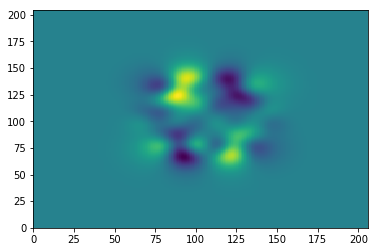

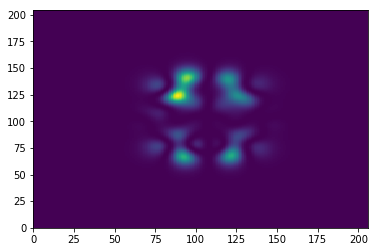

In [22]:
z_ind = 165
plt.pcolormesh(morb_grids[0][0][:, :, z_ind].T)
plt.show()
plt.pcolormesh((morb_grids[0][0][:, :, z_ind]**2).T)
plt.show()

In [25]:
save_morb = morb_grids[0][0]

csu.write_cube_file("/home/kristjan/local_work/morbs_test/test.cube",
                   ase_atoms, new_cell, save_morb.shape, save_morb, origin = origin)

In [24]:
# check for normalization
dv = cell/cell_n
vol_elem = dv[0]*dv[1]*dv[2]
np.sum(morb_grids[0][0]**2)*vol_elem

1.0000008829093778

In [29]:
# compare to cube slice

import ase.io.cube

cube_data, cube_atoms = ase.io.cube.read_cube_data("/home/kristjan/local_work/fused_propeller/PROJ-WFN_05214_1-1_0.cube")

In [30]:
cube_data.shape

(308, 308, 360)

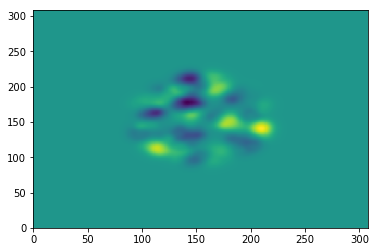

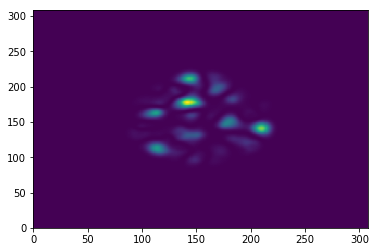

In [36]:
z_ind = 300
plt.pcolormesh(cube_data[:, :, z_ind])
plt.show()
plt.pcolormesh((cube_data[:, :, z_ind]**2))
plt.show()